<a href="https://colab.research.google.com/github/sakasa/notebooks/blob/master/tokyo_covid19_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import requests
import json
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from pytz import timezone
import numpy as np
import seaborn as sns

%matplotlib inline

### Tokyo COVID19 Data
https://github.com/tokyo-metropolitan-gov/covid19

In [2]:
url = 'https://raw.githubusercontent.com/tokyo-metropolitan-gov/covid19/development/data/data.json'

In [3]:
response = requests.get(url)
print(response)
j_res = json.loads(response.text) # json文字列をdictへ
print(j_res.keys())
j_res['patients_summary']['data'][-15:]

<Response [200]>
dict_keys(['contacts', 'querents', 'patients_summary', 'inspections_summary', 'lastUpdate', 'main_summary'])


[{'小計': 5583, '日付': '2022-04-19T08:00:00.000Z'},
 {'小計': 6776, '日付': '2022-04-20T08:00:00.000Z'},
 {'小計': 6713, '日付': '2022-04-21T08:00:00.000Z'},
 {'小計': 5396, '日付': '2022-04-22T08:00:00.000Z'},
 {'小計': 5387, '日付': '2022-04-23T08:00:00.000Z'},
 {'小計': 4936, '日付': '2022-04-24T08:00:00.000Z'},
 {'小計': 3141, '日付': '2022-04-25T08:00:00.000Z'},
 {'小計': 5048, '日付': '2022-04-26T08:00:00.000Z'},
 {'小計': 6052, '日付': '2022-04-27T08:00:00.000Z'},
 {'小計': 5394, '日付': '2022-04-28T08:00:00.000Z'},
 {'小計': 3893, '日付': '2022-04-29T08:00:00.000Z'},
 {'小計': 2979, '日付': '2022-04-30T08:00:00.000Z'},
 {'小計': 3161, '日付': '2022-05-01T08:00:00.000Z'},
 {'小計': 2403, '日付': '2022-05-02T08:00:00.000Z'},
 {'小計': 3357, '日付': '2022-05-03T08:00:00.000Z'}]

In [4]:
def utc_datestr_to_jst_date(datestr):
  #return datetime.datetime.fromisoformat(datestr.replace('Z', '+00:00')).astimezone(timezone('Asia/Tokyo'))
  # for ~Python3.6
  return datetime.datetime.strptime(datestr.split('.')[0].replace('-', '').replace(':', ''), '%Y%m%dT%H%M%S').astimezone(timezone('Asia/Tokyo'))

In [5]:
keys = ['contacts', 'querents', 'patients_summary']

In [6]:
d = j_res
df = pd.DataFrame()
for key in keys:
  k = f'{key.split("_")[0]}_count'
  for v in d[key].values():
    if type(v) is list:
      index = [_v['日付'] for _v in v]
      tmp_df = pd.DataFrame(_v for _v in v)
      tmp_df.index = [utc_datestr_to_jst_date(dt) for dt in tmp_df['日付']]
      tmp_df[k] = tmp_df['小計']
  df = pd.concat([df, tmp_df[k]], axis=1)
df = df.fillna(0).astype('int64')
df.index = [i for i in df.index]
df['datetime'] = df.index
df

,contacts_count,querents_count,patients_count,datetime
2020-01-24 17:00:00+09:00,0,0,1,2020-01-24 17:00:00+09:00
2020-01-25 17:00:00+09:00,0,0,1,2020-01-25 17:00:00+09:00
2020-01-26 17:00:00+09:00,0,0,0,2020-01-26 17:00:00+09:00
2020-01-27 17:00:00+09:00,0,0,0,2020-01-27 17:00:00+09:00
2020-01-28 17:00:00+09:00,0,0,0,2020-01-28 17:00:00+09:00
...,...,...,...,...
2022-04-29 17:00:00+09:00,350,0,3893,2022-04-29 17:00:00+09:00
2022-04-30 17:00:00+09:00,367,0,2979,2022-04-30 17:00:00+09:00
2022-05-01 17:00:00+09:00,232,0,3161,2022-05-01 17:00:00+09:00
2022-05-02 17:00:00+09:00,0,0,2403,2022-05-02 17:00:00+09:00


In [7]:
# 7日移動平均
df1 = df
for key in keys:
  k = key.split('_')[0]
  df1[f'{k}_7d_mov_ave'] = df[f'{k}_count'].rolling('7D').mean()
  # df1[f'{k}_7d_mov_center_ave'] = df[f'{k}_count'].rolling(7, center=True).mean()
  df1[f'{k}_7d_mov_sum'] = df[f'{k}_count'].rolling('7D').sum()
df1.tail()

,contacts_count,querents_count,patients_count,datetime,contacts_7d_mov_ave,contacts_7d_mov_sum,querents_7d_mov_ave,querents_7d_mov_sum,patients_7d_mov_ave,patients_7d_mov_sum
2022-04-29 17:00:00+09:00,350,0,3893,2022-04-29 17:00:00+09:00,402.000000,2814.0,0.0,0.0,4835.857143,33851.0
2022-04-30 17:00:00+09:00,367,0,2979,2022-04-30 17:00:00+09:00,384.428571,2691.0,0.0,0.0,4491.857143,31443.0
2022-05-01 17:00:00+09:00,232,0,3161,2022-05-01 17:00:00+09:00,359.285714,2515.0,0.0,0.0,4238.285714,29668.0
2022-05-02 17:00:00+09:00,0,0,2403,2022-05-02 17:00:00+09:00,294.428571,2061.0,0.0,0.0,4132.857143,28930.0
2022-05-03 17:00:00+09:00,0,0,3357,2022-05-03 17:00:00+09:00,237.857143,1665.0,0.0,0.0,3891.285714,27239.0


In [8]:
df2 = df1
# 日付が年の何週目かを列にセット `'{yy}w{week nnum}`
df2['week_num'] = [f'\'{d.strftime("%y")}w{d.strftime("%V")}' for d in df1.index]
# 曜日の列をセット
df2['week_day'] = [d.strftime('%a') for d in df1.index]
df2.tail(15)

,contacts_count,querents_count,patients_count,datetime,contacts_7d_mov_ave,contacts_7d_mov_sum,querents_7d_mov_ave,querents_7d_mov_sum,patients_7d_mov_ave,patients_7d_mov_sum,week_num,week_day
2022-04-19 17:00:00+09:00,463,0,5583,2022-04-19 17:00:00+09:00,495.000000,3465.0,0.0,0.0,6377.142857,44640.0,'22w16,Tue
2022-04-20 17:00:00+09:00,423,0,6776,2022-04-20 17:00:00+09:00,474.571429,3322.0,0.0,0.0,6166.142857,43163.0,'22w16,Wed
2022-04-21 17:00:00+09:00,422,0,6713,2022-04-21 17:00:00+09:00,466.000000,3262.0,0.0,0.0,5905.142857,41336.0,'22w16,Thu
2022-04-22 17:00:00+09:00,391,0,5396,2022-04-22 17:00:00+09:00,455.285714,3187.0,0.0,0.0,5709.142857,39964.0,'22w16,Fri
2022-04-23 17:00:00+09:00,490,0,5387,2022-04-23 17:00:00+09:00,450.142857,3151.0,0.0,0.0,5507.714286,38554.0,'22w16,Sat
2022-04-24 17:00:00+09:00,408,0,4936,2022-04-24 17:00:00+09:00,448.285714,3138.0,0.0,0.0,5467.142857,38270.0,'22w16,Sun
2022-04-25 17:00:00+09:00,454,0,3141,2022-04-25 17:00:00+09:00,435.857143,3051.0,0.0,0.0,5418.857143,37932.0,'22w17,Mon
2022-04-26 17:00:00+09:00,396,0,5048,2022-04-26 17:00:00+09:00,426.285714,2984.0,0.0,0.0,5342.428571,37397.0,'22w17,Tue
2022-04-27 17:00:00+09:00,370,0,6052,2022-04-27 17:00:00+09:00,418.714286,2931.0,0.0,0.0,5239.000000,36673.0,'22w17,Wed
2022-04-28 17:00:00+09:00,346,0,5394,2022-04-28 17:00:00+09:00,407.857143,2855.0,0.0,0.0,5050.571429,35354.0,'22w17,Thu


In [9]:
# 週毎に集計
groupby_week_num = df2.groupby('week_num', as_index=True)

In [10]:
# 集計結果から平均と合計を取得しデータフレームにセット
patients_week_num_df = pd.DataFrame({
    # 'patients_week_num': df2['week_num'].unique(),
    'patients_week_mean': [m for m in groupby_week_num.agg({'patients_count': 'mean'})['patients_count']], 
    'patients_week_sum': [s for s in groupby_week_num.agg({'patients_count': 'sum'})['patients_count']]
  }, index=[d for d in groupby_week_num.agg({'datetime': 'max'})['datetime']])
patients_week_num_df.tail()

,patients_week_mean,patients_week_sum
2022-04-17 17:00:00+09:00,6723.142857,47062
2022-04-24 17:00:00+09:00,5467.142857,38270
2022-05-01 17:00:00+09:00,4238.285714,29668
2022-05-03 17:00:00+09:00,2880.000000,5760
2022-01-02 17:00:00+09:00,80.000000,160


In [11]:
df3 = pd.concat([
                df2,
                patients_week_num_df.loc[:, ['patients_week_mean', 'patients_week_sum']]
                ], axis=1)
df3.tail(15)

,contacts_count,querents_count,patients_count,datetime,contacts_7d_mov_ave,contacts_7d_mov_sum,querents_7d_mov_ave,querents_7d_mov_sum,patients_7d_mov_ave,patients_7d_mov_sum,week_num,week_day,patients_week_mean,patients_week_sum
2022-04-19 17:00:00+09:00,463,0,5583,2022-04-19 17:00:00+09:00,495.000000,3465.0,0.0,0.0,6377.142857,44640.0,'22w16,Tue,NaN,NaN
2022-04-20 17:00:00+09:00,423,0,6776,2022-04-20 17:00:00+09:00,474.571429,3322.0,0.0,0.0,6166.142857,43163.0,'22w16,Wed,NaN,NaN
2022-04-21 17:00:00+09:00,422,0,6713,2022-04-21 17:00:00+09:00,466.000000,3262.0,0.0,0.0,5905.142857,41336.0,'22w16,Thu,NaN,NaN
2022-04-22 17:00:00+09:00,391,0,5396,2022-04-22 17:00:00+09:00,455.285714,3187.0,0.0,0.0,5709.142857,39964.0,'22w16,Fri,NaN,NaN
2022-04-23 17:00:00+09:00,490,0,5387,2022-04-23 17:00:00+09:00,450.142857,3151.0,0.0,0.0,5507.714286,38554.0,'22w16,Sat,NaN,NaN
2022-04-24 17:00:00+09:00,408,0,4936,2022-04-24 17:00:00+09:00,448.285714,3138.0,0.0,0.0,5467.142857,38270.0,'22w16,Sun,5467.142857,38270.0
2022-04-25 17:00:00+09:00,454,0,3141,2022-04-25 17:00:00+09:00,435.857143,3051.0,0.0,0.0,5418.857143,37932.0,'22w17,Mon,NaN,NaN
2022-04-26 17:00:00+09:00,396,0,5048,2022-04-26 17:00:00+09:00,426.285714,2984.0,0.0,0.0,5342.428571,37397.0,'22w17,Tue,NaN,NaN
2022-04-27 17:00:00+09:00,370,0,6052,2022-04-27 17:00:00+09:00,418.714286,2931.0,0.0,0.0,5239.000000,36673.0,'22w17,Wed,NaN,NaN
2022-04-28 17:00:00+09:00,346,0,5394,2022-04-28 17:00:00+09:00,407.857143,2855.0,0.0,0.0,5050.571429,35354.0,'22w17,Thu,NaN,NaN


### グラフ出力

In [12]:
sns.set()
sns.set_style('whitegrid')

In [13]:
### 日毎の数
x = df3.index
y1_1 = df3['patients_count']
y1_2 = df3['patients_7d_mov_ave']
#y1_3 = df3['patients_7d_mov_center_ave']
# y1_4 = df3['patients_week_mean']

In [14]:
### 週毎の数
# y2_1 = df3['patients_7d_mov_sum']
# y2_2 = df3['patients_week_sum']

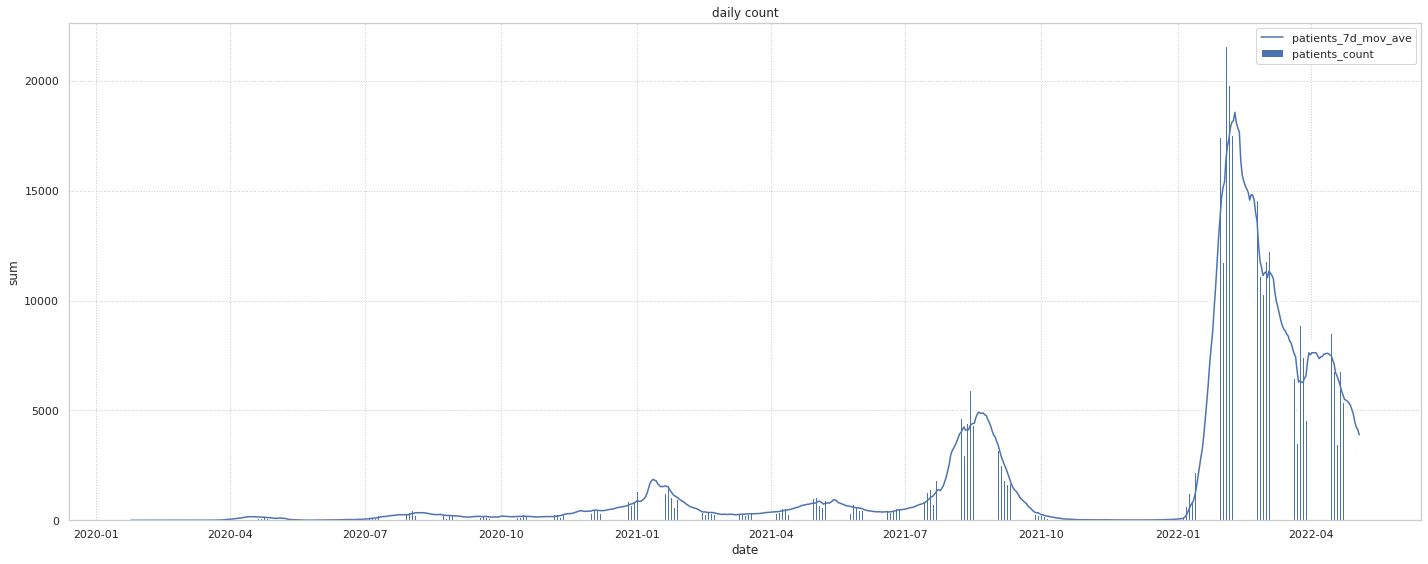

In [15]:
fig, ax = plt.subplots(1,1, figsize=(20, 8))

### 日毎の数
ax.set_title('daily count')
ax.set_xlabel('date')
ax.set_ylabel('sum')
ax.bar(x, y1_1, label='patients_count')
ax.plot(x, y1_2, label='patients_7d_mov_ave')
#ax[0].plot(x, y1_3, label='patients_7d_mov_center_ave')
# ax[0].bar(x, y1_4, label='patients_week_mean')
ax.grid(linestyle=':')
ax.legend()

# ### 週毎の合計
# ax[1].set_title('weekly count')
# ax[1].set_xlabel('date')
# ax[1].set_ylabel('sum')
# ax[1].plot(x, y2_1, label='patients_7d_mov_sum')
# ax[1].bar(x, y2_2, label='patients_week_sum')
# ax[1].grid(linestyle=':')
# ax[1].legend()

plt.tight_layout()

---

In [16]:
def get_date(d: datetime) -> datetime:
  """時間が入った `datetime` を `%Y-%m-%d 00:00:00` の `datetime` に変換します"""
  return datetime.datetime.strptime(d.strftime('%Y-%m-%d'), '%Y-%m-%d')

In [17]:
em_start = datetime.datetime(2020, 4, 7)
em_end = datetime.datetime(2020, 5, 25)
def em_term() -> list:
  """緊急事態宣言期間の日付のリスト"""
  em_term = []
  for i in range((em_end - em_start).days + 1):
    em_term.append(em_start + datetime.timedelta(i))
  return em_term

In [18]:
def emergency(d: datetime) -> int:
  """緊急事態宣言期間中か"""
  return int(get_date(d) in em_term())

In [19]:
def em_passed(d: datetime) -> int:
  """緊急事態宣言から経過日数"""
  d = get_date(d)
  return (d - em_start).days if em_start < d else 0

In [20]:
ds_df = pd.DataFrame({
    'timestamp': [d.timestamp() for d in df3.index], # タイムスタンプ
    'year': np.array(df3.index.strftime('%Y'), dtype=np.int64), # 年
    'month': np.array(df3.index.strftime('%m'), dtype=np.int64), # 月
    'day': np.array(df3.index.strftime('%d'), dtype=np.int64), # 日
    'week_day': df3['week_day'], # 曜日
})
# 曜日をダミー変数化
ds_df = pd.concat([ds_df, pd.get_dummies(ds_df['week_day'])], axis=1)
ds_df = ds_df.drop(columns=['week_day'])

# 経過日数
# ds_df['passed'] = [(d - df3['datetime'][0]).days for d in df3['datetime']]
ds_df['passed'] = [(d - df3.index[0]).days for d in df3.index]
# 緊急事態宣言期間中
ds_df['emergency'] = [emergency(d) for d in df3.index]
# 緊急事態宣言経過日数
ds_df['em_passed'] = [em_passed(d) for d in df3.index]
for key in keys:
  k = key.split('_')[0]
  # 日毎の数
  ds_df[f'{k}_count'] = df3[f'{k}_count']
  # 7日間移動平均
  ds_df[f'{k}_7d_mov_ave'] = df3[f'{k}_7d_mov_ave']
  #ds_df[f'{k}_7d_mov_center_ave'] = df3[f'{k}_7d_mov_center_ave']
  # 7日間移動合計
  ds_df[f'{k}_7d_mov_sum'] = df3[f'{k}_7d_mov_sum']

# 日毎の数
# ds_df['patients_count'] = df3['patients_count']
# 7日間移動平均
# ds_df['patients_7d_mov_ave'] = df3['patients_7d_mov_ave']
#ds_df['7d_mov_center_ave'] = df3['patients_7d_mov_center_ave']
# 7日間移動合計
# ds_df['patients_7d_mov_sum'] = df3['patients_7d_mov_sum']

ds_df = ds_df.reset_index(drop=True)
ds_df.tail(15)

,timestamp,year,month,day,Fri,Mon,Sat,Sun,Thu,Tue,...,em_passed,contacts_count,contacts_7d_mov_ave,contacts_7d_mov_sum,querents_count,querents_7d_mov_ave,querents_7d_mov_sum,patients_count,patients_7d_mov_ave,patients_7d_mov_sum
816,1.650355e+09,2022,4,19,0,0,0,0,0,1,...,742,463,495.000000,3465.0,0,0.0,0.0,5583,6377.142857,44640.0
817,1.650442e+09,2022,4,20,0,0,0,0,0,0,...,743,423,474.571429,3322.0,0,0.0,0.0,6776,6166.142857,43163.0
818,1.650528e+09,2022,4,21,0,0,0,0,1,0,...,744,422,466.000000,3262.0,0,0.0,0.0,6713,5905.142857,41336.0
819,1.650614e+09,2022,4,22,1,0,0,0,0,0,...,745,391,455.285714,3187.0,0,0.0,0.0,5396,5709.142857,39964.0
820,1.650701e+09,2022,4,23,0,0,1,0,0,0,...,746,490,450.142857,3151.0,0,0.0,0.0,5387,5507.714286,38554.0
821,1.650787e+09,2022,4,24,0,0,0,1,0,0,...,747,408,448.285714,3138.0,0,0.0,0.0,4936,5467.142857,38270.0
822,1.650874e+09,2022,4,25,0,1,0,0,0,0,...,748,454,435.857143,3051.0,0,0.0,0.0,3141,5418.857143,37932.0
823,1.650960e+09,2022,4,26,0,0,0,0,0,1,...,749,396,426.285714,2984.0,0,0.0,0.0,5048,5342.428571,37397.0
824,1.651046e+09,2022,4,27,0,0,0,0,0,0,...,750,370,418.714286,2931.0,0,0.0,0.0,6052,5239.000000,36673.0
825,1.651133e+09,2022,4,28,0,0,0,0,1,0,...,751,346,407.857143,2855.0,0,0.0,0.0,5394,5050.571429,35354.0


In [21]:
ds_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 831 entries, 0 to 830
Data columns (total 23 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   timestamp            831 non-null    float64
 1   year                 831 non-null    int64  
 2   month                831 non-null    int64  
 3   day                  831 non-null    int64  
 4   Fri                  831 non-null    uint8  
 5   Mon                  831 non-null    uint8  
 6   Sat                  831 non-null    uint8  
 7   Sun                  831 non-null    uint8  
 8   Thu                  831 non-null    uint8  
 9   Tue                  831 non-null    uint8  
 10  Wed                  831 non-null    uint8  
 11  passed               831 non-null    int64  
 12  emergency            831 non-null    int64  
 13  em_passed            831 non-null    int64  
 14  contacts_count       831 non-null    int64  
 15  contacts_7d_mov_ave  831 non-null    flo

In [22]:
ds_df.describe()

,timestamp,year,month,day,Fri,Mon,Sat,Sun,Thu,Tue,...,em_passed,contacts_count,contacts_7d_mov_ave,contacts_7d_mov_sum,querents_count,querents_7d_mov_ave,querents_7d_mov_sum,patients_count,patients_7d_mov_ave,patients_7d_mov_sum
count,8.310000e+02,831.000000,831.000000,831.000000,831.000000,831.000000,831.000000,831.000000,831.000000,831.000000,...,831.000000,831.000000,831.000000,831.000000,831.000000,831.000000,831.000000,831.000000,831.000000,831.000000
mean,1.615709e+09,2020.735259,6.086643,15.761733,0.143201,0.143201,0.143201,0.143201,0.141998,0.143201,...,344.339350,679.871239,679.343275,4755.398315,443.464501,443.464501,3104.251504,1741.955475,1730.454409,12113.161252
std,2.073888e+07,0.700909,3.460580,8.847900,0.350489,0.350489,0.350489,0.350489,0.349258,0.350489,...,234.858682,546.114125,533.535669,3734.755534,765.332504,704.638416,4932.468911,3601.617345,3519.722012,24638.063734
min,1.579853e+09,2020.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.597781e+09,2020.000000,3.000000,8.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,133.500000,334.000000,338.714286,2371.000000,0.000000,0.000000,0.000000,67.000000,75.142857,526.000000
50%,1.615709e+09,2021.000000,6.000000,16.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,341.000000,517.000000,530.285714,3712.000000,0.000000,0.000000,0.000000,302.000000,309.714286,2168.000000
75%,1.633637e+09,2021.000000,9.000000,23.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,548.500000,824.000000,823.642857,5765.500000,872.000000,1005.357143,7037.500000,956.500000,885.857143,6201.000000
max,1.651565e+09,2022.000000,12.000000,31.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,756.000000,3277.000000,2723.000000,19061.000000,4060.000000,2574.142857,18019.000000,21562.000000,18562.285714,129936.000000


In [23]:
ds_df.corr()

,timestamp,year,month,day,Fri,Mon,Sat,Sun,Thu,Tue,...,em_passed,contacts_count,contacts_7d_mov_ave,contacts_7d_mov_sum,querents_count,querents_7d_mov_ave,querents_7d_mov_sum,patients_count,patients_7d_mov_ave,patients_7d_mov_sum
timestamp,1.000000e+00,0.911154,0.064323,0.003111,-0.003408,0.001704,-0.001704,-3.109011e-16,0.000848,0.003408,...,0.998864,-0.045094,-0.031937,-0.031935,-0.618257,-0.663635,-0.663635,0.552457,0.565810,0.565811
year,9.111543e-01,1.000000,-0.351150,-0.030000,-0.002432,0.002473,0.002473,2.472859e-03,-0.003743,0.002473,...,0.916296,0.065104,0.078299,0.078301,-0.608570,-0.660989,-0.660989,0.662173,0.673180,0.673181
month,6.432291e-02,-0.351150,1.000000,-0.003889,-0.002295,-0.002295,-0.010242,-6.268458e-03,0.010742,0.002672,...,0.049166,-0.262559,-0.263457,-0.263455,0.070343,0.095172,0.095172,-0.349975,-0.345691,-0.345690
day,3.111054e-03,-0.030000,-0.003889,1.000000,0.005188,0.002080,0.003634,2.857058e-03,0.003554,-0.010352,...,0.003648,0.015640,0.000451,0.000449,0.004680,-0.005369,-0.005369,-0.011481,-0.017973,-0.017974
Fri,-3.408422e-03,-0.002432,-0.002295,0.005188,1.000000,-0.167135,-0.167135,-1.671348e-01,-0.166314,-0.167135,...,-0.003021,-0.017144,-0.001398,-0.001398,0.023939,-0.000618,-0.000618,0.017564,-0.000809,-0.000809
Mon,1.704211e-03,0.002473,-0.002295,0.002080,-0.167135,1.000000,-0.167135,-1.671348e-01,-0.166314,-0.167135,...,0.001722,0.037625,-0.000847,-0.000846,0.096334,-0.000618,-0.000618,-0.067604,0.000382,0.000383
Sat,-1.704211e-03,0.002473,-0.010242,0.003634,-0.167135,-0.167135,1.000000,-1.671348e-01,-0.166314,-0.167135,...,-0.001440,0.046519,-0.001060,-0.001060,-0.112425,-0.000618,-0.000618,0.011686,-0.000393,-0.000394
Sun,-3.109011e-16,0.002473,-0.006268,0.002857,-0.167135,-0.167135,-0.167135,1.000000e+00,-0.166314,-0.167135,...,0.000141,-0.025075,-0.000847,-0.000846,-0.103626,-0.000618,-0.000618,-0.011529,0.000047,0.000047
Thu,8.479225e-04,-0.003743,0.010742,0.003554,-0.166314,-0.166314,-0.166314,-1.663143e-01,1.000000,-0.166314,...,0.000440,-0.012070,0.002666,0.002667,0.029799,0.001551,0.001551,0.033135,0.000338,0.000339
Tue,3.408422e-03,0.002473,0.002672,-0.010352,-0.167135,-0.167135,-0.167135,-1.671348e-01,-0.166314,1.000000,...,0.003302,-0.018705,-0.000847,-0.000846,0.038092,-0.000618,-0.000618,-0.011031,0.000851,0.000851


---

In [24]:
ds_df.columns

Index(['timestamp', 'year', 'month', 'day', 'Fri', 'Mon', 'Sat', 'Sun', 'Thu',
       'Tue', 'Wed', 'passed', 'emergency', 'em_passed', 'contacts_count',
       'contacts_7d_mov_ave', 'contacts_7d_mov_sum', 'querents_count',
       'querents_7d_mov_ave', 'querents_7d_mov_sum', 'patients_count',
       'patients_7d_mov_ave', 'patients_7d_mov_sum'],
      dtype='object')

In [25]:
_df = ds_df.copy()
_df = _df.drop(['year', 'month', 'day', 
          'contacts_7d_mov_ave', 'contacts_7d_mov_sum', 
          'querents_7d_mov_ave', 'querents_7d_mov_sum', 
          ], axis=1)
_df

,timestamp,Fri,Mon,Sat,Sun,Thu,Tue,Wed,passed,emergency,em_passed,contacts_count,querents_count,patients_count,patients_7d_mov_ave,patients_7d_mov_sum
0,1.579853e+09,1,0,0,0,0,0,0,0,0,0,0,0,1,1.000000,1.0
1,1.579939e+09,0,0,1,0,0,0,0,1,0,0,0,0,1,1.000000,2.0
2,1.580026e+09,0,0,0,1,0,0,0,2,0,0,0,0,0,0.666667,2.0
3,1.580112e+09,0,1,0,0,0,0,0,3,0,0,0,0,0,0.500000,2.0
4,1.580198e+09,0,0,0,0,0,1,0,4,0,0,0,0,0,0.400000,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
826,1.651219e+09,1,0,0,0,0,0,0,826,0,752,350,0,3893,4835.857143,33851.0
827,1.651306e+09,0,0,1,0,0,0,0,827,0,753,367,0,2979,4491.857143,31443.0
828,1.651392e+09,0,0,0,1,0,0,0,828,0,754,232,0,3161,4238.285714,29668.0
829,1.651478e+09,0,1,0,0,0,0,0,829,0,755,0,0,2403,4132.857143,28930.0


In [26]:
_df2 = _df[['timestamp', 'passed', 'emergency', 'patients_count', 'patients_7d_mov_ave', 'patients_7d_mov_sum']]
_df2

,timestamp,passed,emergency,patients_count,patients_7d_mov_ave,patients_7d_mov_sum
0,1.579853e+09,0,0,1,1.000000,1.0
1,1.579939e+09,1,0,1,1.000000,2.0
2,1.580026e+09,2,0,0,0.666667,2.0
3,1.580112e+09,3,0,0,0.500000,2.0
4,1.580198e+09,4,0,0,0.400000,2.0
...,...,...,...,...,...,...
826,1.651219e+09,826,0,3893,4835.857143,33851.0
827,1.651306e+09,827,0,2979,4491.857143,31443.0
828,1.651392e+09,828,0,3161,4238.285714,29668.0
829,1.651478e+09,829,0,2403,4132.857143,28930.0


In [27]:
sns.set(style="ticks", color_codes=True)
#sns.pairplot(data=_df)

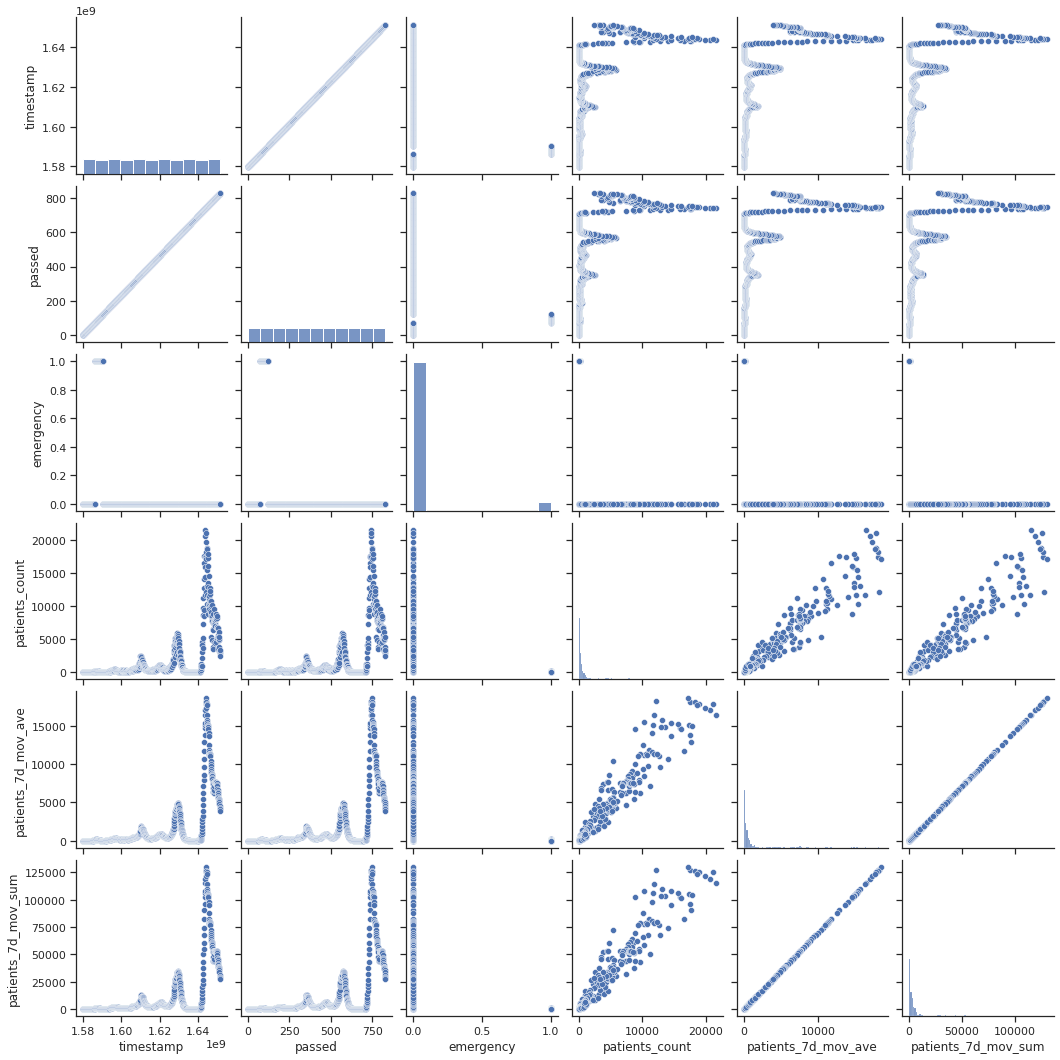

In [28]:
sns.pairplot(data=_df2)

In [29]:
!python -V

Python 3.7.13


In [30]:
!pip freeze

absl-py==1.0.0
alabaster==0.7.12
albumentations==0.1.12
altair==4.2.0
appdirs==1.4.4
argon2-cffi==21.3.0
argon2-cffi-bindings==21.2.0
arviz==0.12.0
astor==0.8.1
astropy==4.3.1
astunparse==1.6.3
atari-py==0.2.9
atomicwrites==1.4.0
attrs==21.4.0
audioread==2.1.9
autograd==1.4
Babel==2.10.1
backcall==0.2.0
beautifulsoup4==4.6.3
bleach==5.0.0
blis==0.4.1
bokeh==2.3.3
Bottleneck==1.3.4
branca==0.5.0
bs4==0.0.1
CacheControl==0.12.11
cached-property==1.5.2
cachetools==4.2.4
catalogue==1.0.0
certifi==2021.10.8
cffi==1.15.0
cftime==1.6.0
chardet==3.0.4
charset-normalizer==2.0.12
click==7.1.2
cloudpickle==1.3.0
cmake==3.22.4
cmdstanpy==0.9.5
colorcet==3.0.0
colorlover==0.3.0
community==1.0.0b1
contextlib2==0.5.5
convertdate==2.4.0
coverage==3.7.1
coveralls==0.5
crcmod==1.7
cufflinks==0.17.3
cvxopt==1.2.7
cvxpy==1.0.31
cycler==0.11.0
cymem==2.0.6
Cython==0.29.28
daft==0.0.4
dask==2.12.0
datascience==0.10.6
debugpy==1.0.0
decorator==4.4.2
defusedxml==0.7.1
descartes==1.1.0
dill==0.3.4
distributed=